# [GIS] 도로 네트워크 데이터를 활용한 도시의 공간영역 분할  

[yg's blog]() 에 포스팅한 내용의 source code입니다.  
  
---

## Data 로딩  

In [204]:
import matplotlib.pyplot as plt

# geospatial
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import linemerge
from fiona.crs import from_string
epsg5179 = from_string("+proj=tmerc +lat_0=38 +lon_0=127.5 +k=0.9996 +x_0=1000000 +y_0=2000000 +ellps=GRS80 +units=m +no_defs")

data_dir = '11000'

In [2]:
sido_bnd = gpd.GeoDataFrame.from_file(data_dir + "/TL_SCCO_CTPRVN.shp", encoding='cp949')
sido_bnd.crs = epsg5179
sido_bnd['geometry'] = sido_bnd.buffer(0)

In [66]:
road = gpd.GeoDataFrame.from_file(data_dir + "/TL_SPRD_MANAGE.shp", encoding='cp949')
road.crs = epsg5179
road['ROA_CLS_SE'] = road['ROA_CLS_SE'].astype(int)

In [67]:
road_bt = 12  #도로폭 
road_cls = 3  #도로 위계가 "집산도로 이상"의 도로
road = road[(road['ROAD_BT']>=road_bt) & (road['ROA_CLS_SE']<=road_cls)].reset_index(drop=True)

In [137]:
road[["RN","ROAD_BT","ROAD_LT","ROA_CLS_SE","geometry"]].sample(10)

,RN,ROAD_BT,ROAD_LT,ROA_CLS_SE,geometry
1210,대방천로,20.0,40.0,3,"LINESTRING (948575.050 1944614.652, 948550.711..."
1191,고덕로,16.0,5055.0,3,"LINESTRING (966884.816 1950670.268, 966997.857..."
1047,장충단로,25.0,2800.0,3,"LINESTRING (955808.365 1950165.313, 955802.283..."
1400,영중로,30.0,1761.0,3,"LINESTRING (947563.533 1946512.639, 947558.265..."
490,독산로,20.0,3723.0,3,"LINESTRING (947514.991 1939580.411, 947515.209..."
592,통일로,42.0,57569.0,3,"LINESTRING (950955.577 1954490.421, 950940.136..."
1126,흑석로,15.0,45.0,3,"LINESTRING (951650.338 1945217.213, 951648.910..."
329,창전로,22.0,1034.0,3,"LINESTRING (949662.010 1949471.363, 949646.513..."
1188,천호대로,51.0,15510.0,2,"LINESTRING (965497.759 1949441.848, 965498.425..."
149,종로,40.0,83.0,3,"LINESTRING (956404.112 1952527.964, 956411.704..."


(933183.6391834269, 973919.1846118927, 1935149.467567827, 1968503.2392231026)

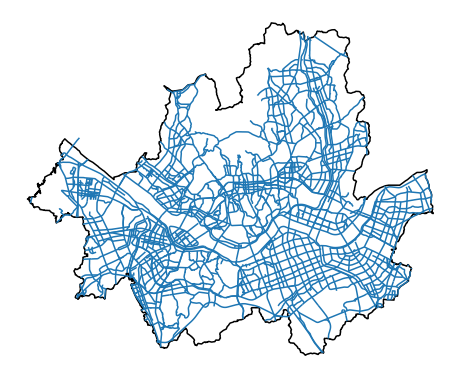

In [73]:
ax = sido_bnd.boundary.plot(color='black', figsize=(8,8))
road.plot(ax=ax)
ax.axis(False)

## Linemerge와 buffer를 이용한 도로 네트워크 전처리  

In [360]:
road_merged = road.unary_union 
print('Road : '+str(len(road_merged))+' segments')
road_merged_broken=linemerge(road_merged)
print('merged Road : '+str(len(road_merged_broken))+' segments')
print(road_merged_broken.type)

Road : 7191 segments
merged Road : 6833 segments
MultiLineString


- buffer의 parameter예시

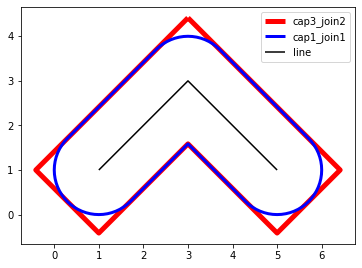

In [361]:
test_line = LineString([(1,1),(3,3),(5,1)])
test_line = gpd.GeoSeries(test_line)

ax = test_line.buffer(1,cap_style=3, join_style=2).boundary.plot(figsize=(6,6),color='red',linewidth=5, label="cap3_join2")
test_line.buffer(1,cap_style=1, join_style=1).boundary.plot(ax=ax,color='blue', linewidth=3,  label="cap1_join1")
test_line.plot(ax=ax, color='black', label="line")
plt.legend()
plt.show()

In [370]:
df = gpd.GeoDataFrame({'geometry':road_merged_broken}, geometry='geometry').reset_index().rename({'index':'id'}, axis=1)
df.crs = epsg5179

df['buffer'] = df.buffer(0.1, cap_style=3,join_style=2)
df = df.set_geometry("buffer")
disv = df.unary_union
disv = gpd.GeoDataFrame({'geometry':disv}, geometry='geometry')
disv.crs = epsg5179

In [373]:
result = gpd.overlay(sido_bnd, disv, how='difference')
result = gpd.GeoDataFrame({'geometry':list(result.geometry[0])}, geometry='geometry')
result['geometry'] = result.buffer(0.15, cap_style=3,join_style=2).buffer(-0.05, cap_style=3,join_style=2)
result.crs = epsg5179

In [375]:
result = result.explode().reset_index(drop=True)
result['area'] = result.area
result = result[result['area']>=1].reset_index().rename({'index':'id'}, axis=1)

print("Total Areas:",len(result))

Total Areas: 1238


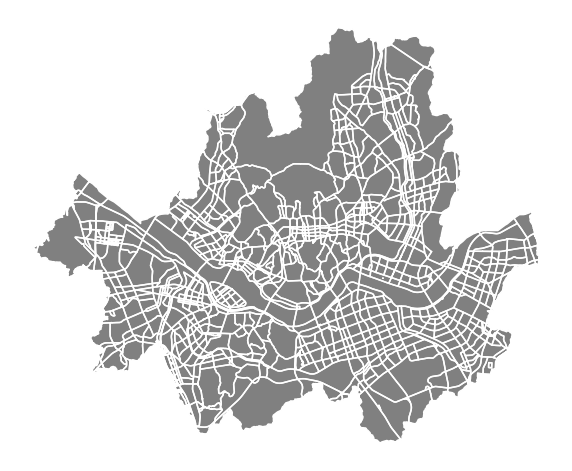

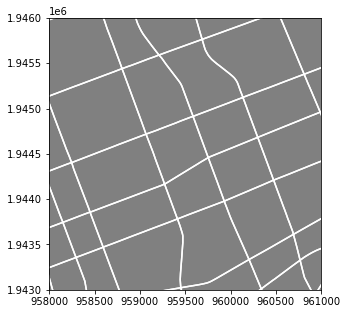

In [377]:
ax = result.plot(figsize=(10,10), color='grey')
result.boundary.plot(ax=ax, color='white')
ax.axis(False)
plt.show()

# 강남구 부근만 확대
ax = result.plot(figsize=(5,5), color='grey')
result.boundary.plot(ax=ax, color='white')
plt.ylim([1943000,1946000])
plt.xlim([958000,961000])
plt.show()

## Filling Holes in Polygon  

In [392]:
result[result.boundary.geom_type=='MultiLineString']

,id,geometry,area
50,53,"POLYGON ((967919.376 1941743.219, 967937.161 1...",7.587746e+05
274,277,"POLYGON ((959798.112 1940576.647, 959798.112 1...",5.008997e+06
360,364,"POLYGON ((960078.740 1949128.005, 960078.740 1...",6.724393e+05
413,417,"POLYGON ((949597.545 1958564.584, 949597.545 1...",4.690768e+07
540,544,"POLYGON ((957314.562 1952185.583, 957314.562 1...",1.950646e+05


In [400]:
holes_poly = result[result.boundary.geom_type=="MultiLineString"].reset_index(drop=True)
fine_poly = result[result.boundary.geom_type!="MultiLineString"].reset_index(drop=True)

for i in range(len(holes_poly)):
    bnd = holes_poly.geometry.loc[i].boundary
    ls_area = {}
    for j in list(bnd):
        pl = Polygon(j)
        ls_area[Polygon(j).area] = pl #면적계산
    print("max area in 1 polygon :", max(ls_area))
    final = ls_area[max(ls_area)] # 가장 큰 면적을 가진 boundary만 Polygon으로 사용
    holes_poly.loc[i, 'geometry'] = final
# holes_poly.plot()
result_final = fine_poly.append(holes_poly, ignore_index=True)

max area in 1 polygon : 840398.3580723975
max area in 1 polygon : 5022022.670197196
max area in 1 polygon : 672940.338217593
max area in 1 polygon : 46907723.95667414
max area in 1 polygon : 195064.6522914894


In [401]:
remove_id = []
for i in range(len(result_final)):
    stand_poly = result_final.iloc[i].geometry
    rest_poly = result_final.iloc[result6.index != i]
    ls_ = rest_poly['id'][rest_poly.within(stand_poly)].tolist()
    if len(ls_) != 0:
        print(len(ls_))
        remove_id += ls_
result_final = result_final[~result_final['id'].isin(remove_id)].reset_index(drop=True)
result_final['id'] = result_final.index

print("Total areas:" ,len(result_final))

1
1
1
Total areas: 1235


In [402]:
result_final.to_file("result/"+"result_final.shp")